# Занятие 3: Метод k-ближайших соседей

In [1]:
# https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

## Загружаем библиотеки

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

import csv

## Загружаем и анализируем датасет о Uplift Modeling: предсказание, конвертируется ли потенциальный клиент после просмотра рекламы

In [3]:
# https://en.wikipedia.org/wiki/Churn_rate
data_file = "../data/criteo-uplift-v2.1.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')

print(df.columns)
print(df.shape)

Index(['Unnamed: 0', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')
(81142, 17)


In [4]:
# Оставим только числа
num_cols = [col for col in df.columns.values if is_numeric_dtype(df[col])]
df = df[num_cols]
df = df.astype(float)

print(df.columns)

Index(['Unnamed: 0', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')


In [5]:
# Посмотрим корреляции
for col in df.columns.values:
    print(col, " corr: ", df[col].corr(df['conversion']))

Unnamed: 0  corr:  0.6955134052448174
f0  corr:  -0.5650516104596752
f1  corr:  0.23252701636568793
f2  corr:  0.04056555471690683
f3  corr:  -0.532267519777223
f4  corr:  0.5791488317866015
f5  corr:  -0.31346889747615353
f6  corr:  -0.4495427229993004
f7  corr:  0.2751074219605884
f8  corr:  -0.8332728223719034
f9  corr:  0.7739847980322742
f10  corr:  0.48697708895225483
f11  corr:  -0.4648496429334603
treatment  corr:  -0.2295912726280097
conversion  corr:  0.9999999999999998
visit  corr:  0.9800853676618588
exposure  corr:  0.5958087412824677


### Объединяем

In [6]:
# выберем лучшие фичи
features = ['f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f11']
df = df[features+['conversion']]
print (df.columns)

Index(['f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f11', 'conversion'], dtype='object')


### Визуализируем данные

No handles with labels found to put in legend.


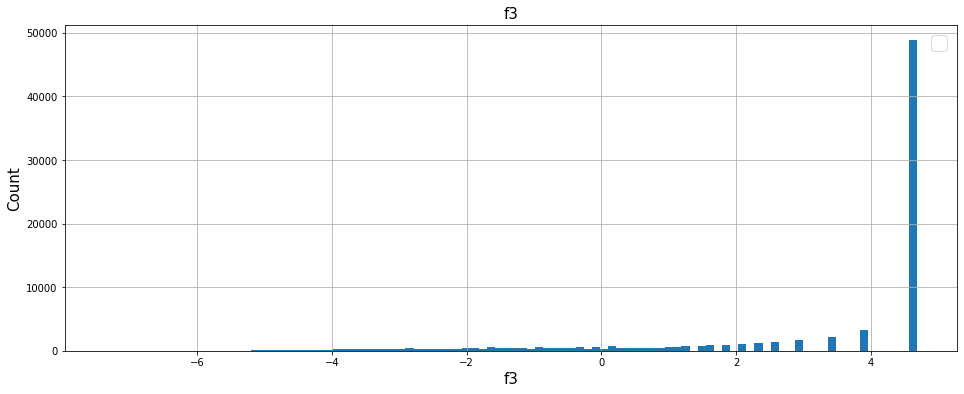

No handles with labels found to put in legend.


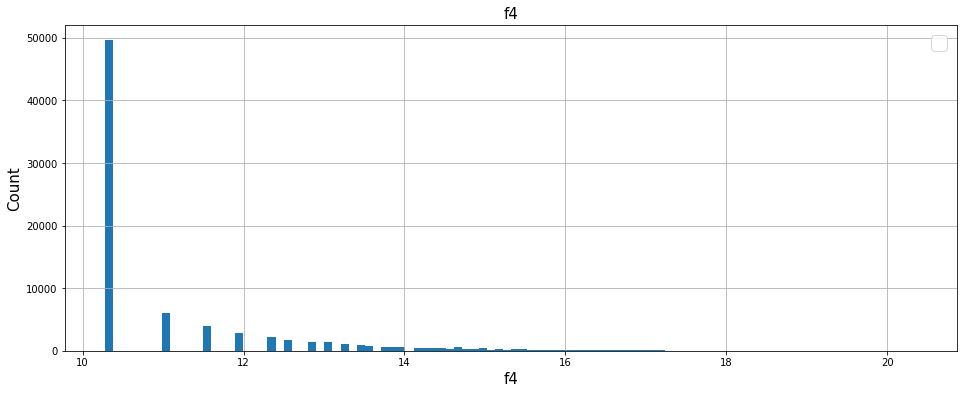

No handles with labels found to put in legend.


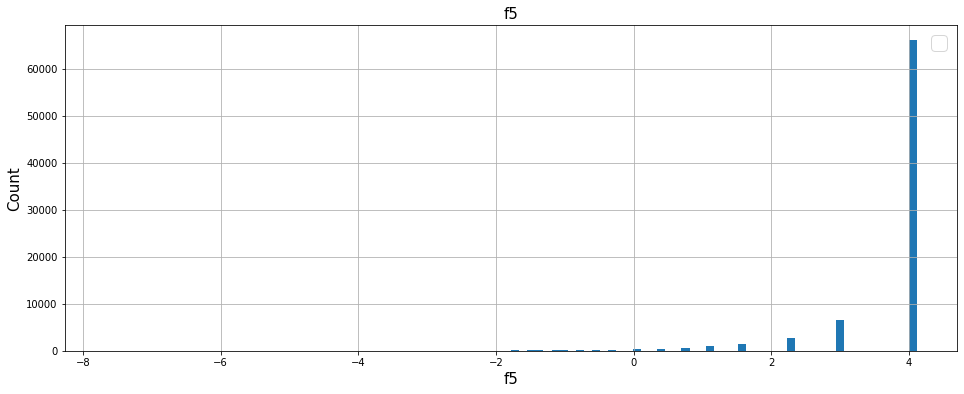

No handles with labels found to put in legend.


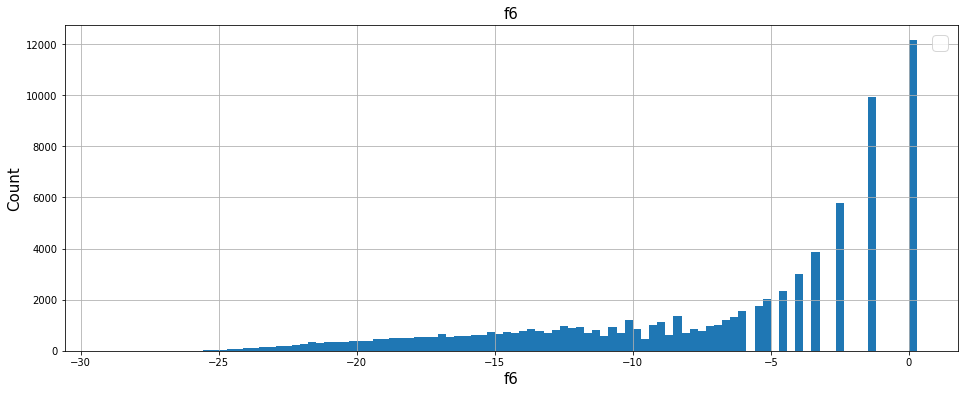

No handles with labels found to put in legend.


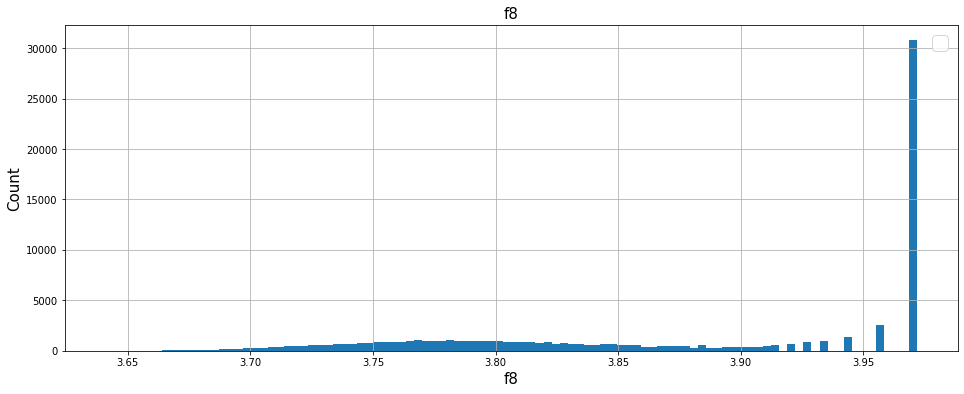

No handles with labels found to put in legend.


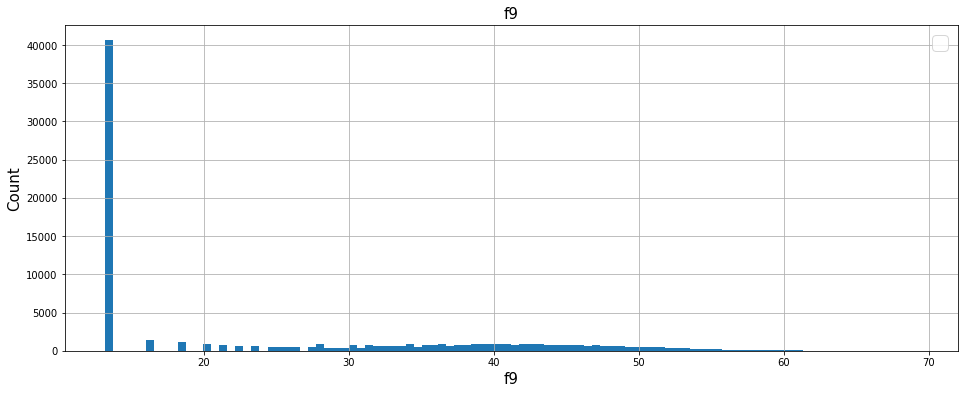

No handles with labels found to put in legend.


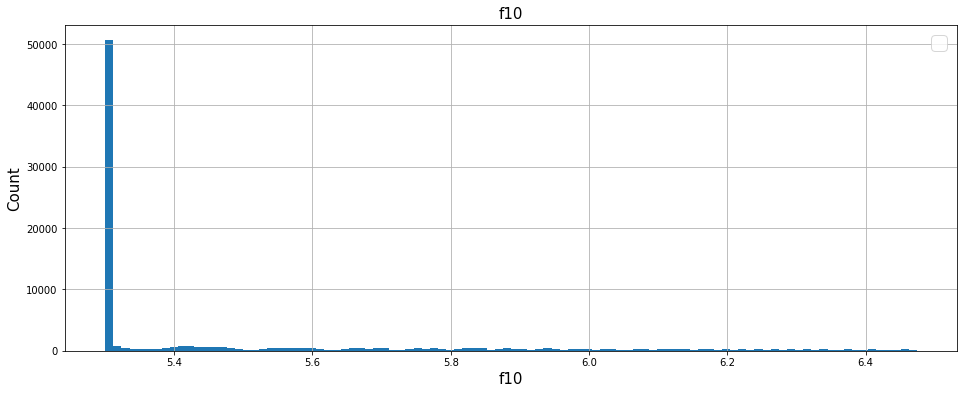

No handles with labels found to put in legend.


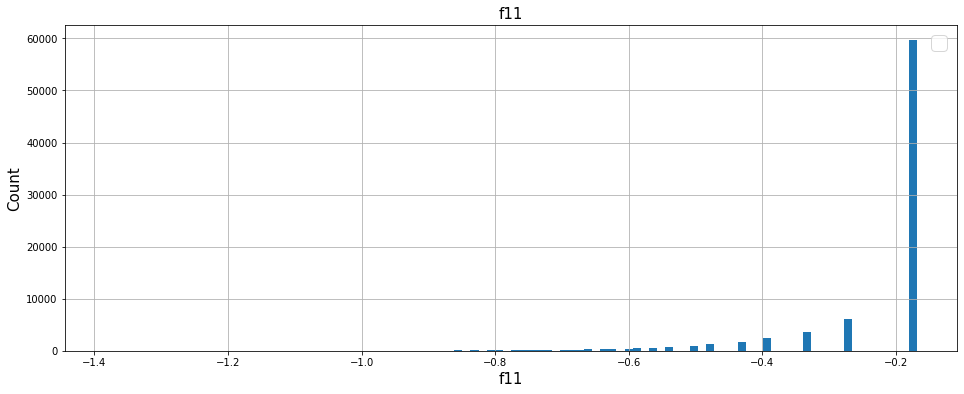

No handles with labels found to put in legend.


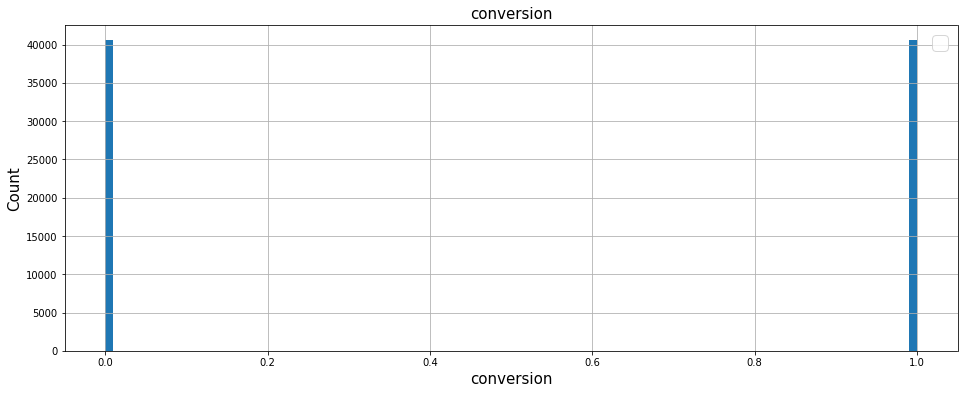

In [7]:
for col in df.columns:
    df[col].hist(bins=100, figsize=(16,6))
    plt.title(col, fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.legend(fontsize=20)
    plt.show()

<AxesSubplot:xlabel='conversion', ylabel='f8'>

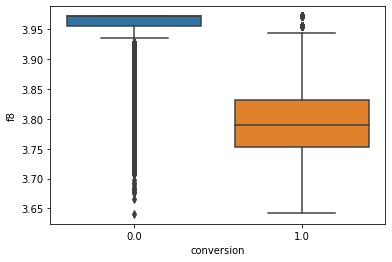

In [8]:
sns.boxplot(x = df["conversion"], y = df["f8"])

<AxesSubplot:xlabel='conversion', ylabel='f9'>

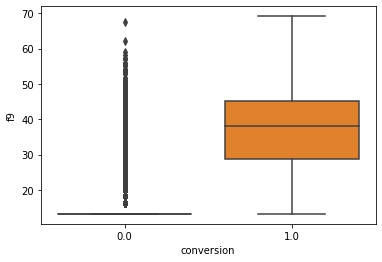

In [9]:
sns.boxplot(x = df["conversion"], y = df["f9"])

## Найдем и уберем outlier

In [10]:
# Найти outlier
z = np.abs(stats.zscore(df))
threshold = 3
print(np.where(z > threshold))

# Убрать outlier
df = df[(z < threshold).all(axis=1)]

(array([  849,   917,   962, ..., 81040, 81061, 81123]), array([6, 6, 6, ..., 6, 6, 0]))


In [11]:
# Посмотрим статистику о главных классах
df_conv1=df[df['conversion']==1]
df_conv0=df[df['conversion']==0]
print('Conversion=1: ',len(df_conv1.index),' cases')
print('Conversion=0: ',len(df_conv0.index),' cases')

Conversion=1:  35694  cases
Conversion=0:  40335  cases


## Нормализируем дата

In [12]:
for col in df.columns:
    if col[0]=='f':
        mean = df[col].mean()
        stdev = df[col].std()
        df[col]=(df[col]-mean)/stdev
y_data = np.expand_dims(df['conversion'],axis=1)
y_data = df['conversion']
x_data= np.array(df[features])

In [14]:
# Проверим нормализованы ли данные
for col in df.columns:
    if col[0]=='f':
        mean = df[col].mean().round(3)
        stdev = df[col].std().round(3)
        print("For feature ", col, " mean is ", mean, " std is ", stdev)

For feature  f3  mean is  0.0  std is  1.0
For feature  f4  mean is  0.0  std is  1.0
For feature  f5  mean is  -0.0  std is  1.0
For feature  f6  mean is  0.0  std is  1.0
For feature  f8  mean is  0.0  std is  1.0
For feature  f9  mean is  -0.0  std is  1.0
For feature  f10  mean is  0.0  std is  1.0
For feature  f11  mean is  0.0  std is  1.0


## Разделяем дата на выборки

In [15]:
# 20% данных будем использовать как validation dataset
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 60823.
Data points in val set: 15206.
Shape of features in training data: (60823, 8)
Shape of output in training data: (60823,)
Shape of features in val data: (15206, 8)
Shape of output in val data: (15206,)


## Применяем метод К ближайших соседей

In [17]:
# Потроим "модель"
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
K = 13
knn = KNeighborsClassifier(n_neighbors=K) #, weights = "distance")
knn.fit(X_train, y_train)

# Применяем
y_pred = knn.predict(X_val)

# Посчитаем качество прогнозов
acc_sc = accuracy_score(y_val, y_pred) 
print("Acc:", acc_sc)

# https://en.wikipedia.org/wiki/Precision_and_recall
prec = precision_score(y_val, y_pred)
print("Prec:", prec)

rec = recall_score(y_val, y_pred)
print("Rec:", rec)

# https://en.wikipedia.org/wiki/F-score
f1_sc = f1_score(y_val, y_pred)
print("F1 score: ", f1_sc)

Acc: 0.9202288570301197
Prec: 0.9108315863032844
Rec: 0.9189227298364354
F1 score:  0.9148592686179546


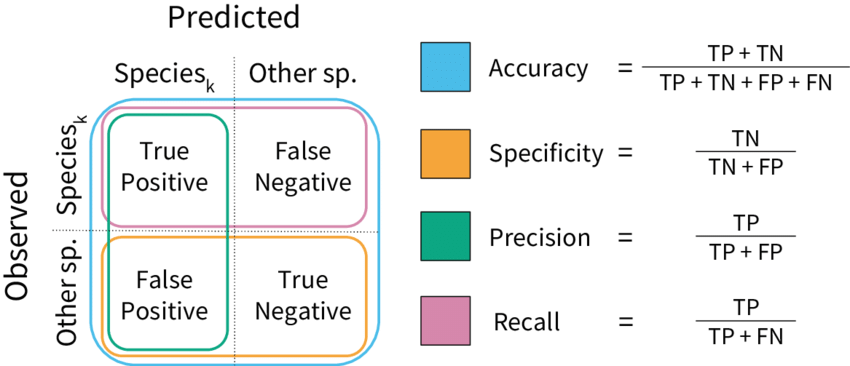

In [18]:
from IPython.display import Image
Image(filename='files/metrics.png')


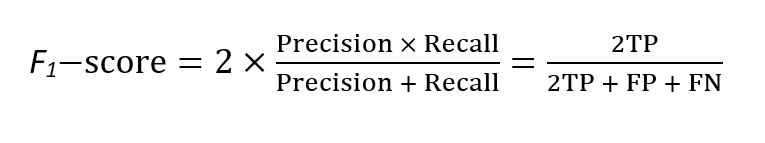

In [19]:
from IPython.display import Image
Image(filename='files/f1_score.png')


## Сравним с линейной регрессией

In [20]:
# Построим регрессию
regr = LinearRegression()
regr.fit(X_train, y_train)

# прогнозируем
y_pred = regr.predict(X_val)

# Округлим чтобы сделать прогноз 1 или 0
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()

# https://en.wikipedia.org/wiki/Precision_and_recall
prec = precision_score(y_val, y_pred)
print("Prec:", prec)

rec = recall_score(y_val, y_pred)
print("Rec:", rec)

# https://en.wikipedia.org/wiki/F-score
f1_sc = f1_score(y_val, y_pred)
print("F1 score: ", f1_sc)

Prec: 0.9283914010378058
Rec: 0.8829667230682459
F1 score:  0.9051094890510949


## Сравним с полиномиальной регрессией

In [21]:
# Строим регрессию

# Задаем степень полинома
polynomial_degree = 3

# Описываем полиномиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коэффициенты 
polyreg.fit(X_train, y_train)

# Предсказываем
poly_pred = polyreg.predict(X_val)
poly_pred = np.clip(poly_pred, 0, 1)
poly_pred = poly_pred.round()


acc_sc = accuracy_score(y_val, poly_pred) # normalize=False)
print("Acc:", acc_sc)

# https://en.wikipedia.org/wiki/Precision_and_recall
prec = precision_score(y_val, poly_pred)
print("Prec:", prec)

rec = recall_score(y_val, poly_pred)
print("Rec:", rec)

f1_sc = f1_score(y_val, poly_pred) # normalize=False)
print("F1 score: ", f1_sc)

Acc: 0.9245692489806655
Prec: 0.9177793394237527
Rec: 0.9207557811618725
F1 score:  0.9192651509819103


In [22]:
# побробуем разные значения p

## Сравним с логистической регрессией

In [23]:
# Построим логистическую регрессию
logis_reg = LogisticRegression()

# Находим коэффициенты 
logis_reg.fit(X_train, y_train)

# Предсказываем
log_pred = logis_reg.predict(X_val).round()


acc_sc = accuracy_score(y_val, log_pred) 
print("Acc:", acc_sc)

prec = precision_score(y_val, log_pred)
print("Prec:", prec)

rec = recall_score(y_val, log_pred)
print("Rec:", rec)

f1_sc = f1_score(y_val, log_pred)
print("F1 score: ", f1_sc)




Acc: 0.9199658029725108
Prec: 0.927521467035366
Rec: 0.8986181613085167
F1 score:  0.9128410799971353
